In [53]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay,  average_precision_score
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
# from miga.const import ID2LABELS_SMG_SHORT as ID2LABELS
from mac2024.const import ID2LABELS as ID2LABELS
from mac2024.const import fine2coarse, COARSE_LABEL, COARSE2FINE
import seaborn as sns
import datetime

In [54]:
COARSE2FINE


{0: range(0, 5),
 1: range(5, 11),
 2: range(11, 24),
 3: range(24, 32),
 4: range(32, 38),
 5: range(38, 46),
 6: range(48, 52)}

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting the maximum for numerical stability
    return e_x / e_x.sum(axis=0)

from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, file_names):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, file_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    TH = 0.4
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        # match = re.match(r'(\d+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        # match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        if match:
    

            # index = int(match.group(1))
            index = match.group(1)
            
            # Extract model predictions and convert to list using ast
            logits_str = match.group(2)
            logits = list(ast.literal_eval(logits_str))
            
            
            predictions = ((np.array(logits)>TH).astype(int)).tolist()


            # Extract targets and convert to list using ast
            targets_str = f'[{match.group(3)}]'
            targets = list(np.array(ast.literal_eval(targets_str)))

            
            row_data = logits + predictions + targets 
            row_data = np.array(row_data)
            data.append(row_data)
            # indecies.append(int(index))
            indecies.append(index)

    # Create column names
    logit_columns = [f"logit-{name}" for name in feature_names]
    pred_columns = [f"pred-{name}" for name in feature_names]
    gt_columns = [f"gt-{name}" for name in feature_names]
    columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)
    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)

In [56]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8'
# run_name = 'eval_on_original'
# 'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments\resampled_64_multi_update_freq_8\eval after downsampleing'
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = 'mac_multi'

In [57]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset','weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [58]:
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# # path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')

# path_to_log = glob(osp.join(experiment_folder,run_name,'','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval after downsampleing','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'validation_best_after_100_epochs','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'delete_later','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval_28','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'eval_93','*.txt'))
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse','eval_49')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse','eval_71')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse_70','eval_9')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse_70','eval_29')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse_70','eval_29_best')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse_70','eval_on_train')
# path_to_log_folder = osp.join(experiment_folder,run_name,'split_loss_fine_coarse_70','test')
# path_to_log_folder = osp.join(experiment_folder,run_name,'densepose_input','eval_149')
path_to_log_folder = osp.join(experiment_folder,run_name,'densepose_input','test_151')

path_to_log = glob(osp.join(path_to_log_folder,'*.txt'))


path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','train.csv')



# Get names of file names from the csv file
df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)
# df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,'')
# data, columns = load_and_parse_txt(path_to_log, feature_names)
df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

C:\Users\user\AppData\Local\Temp\ipykernel_32716\1208271820.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['filenames'] = file_names
C:\Users\user\AppData\Local\Temp\ipykernel_32716\1208271820.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['log_name'] = osp.basename(path)


In [59]:
# df_csv['label_txt'] = df_csv['metadata'].apply(lambda x: ast.literal_eval(x)['label_txt'])
# df_csv.loc[df_csv['label_txt']=='scratching or touching hindbrain']

In [60]:
fine_labels = feature_names[:52]
coarse_labels = feature_names[52:]


In [61]:
def filter_df_by_labels(df_in, labels):
    df_out = df_in[[a for a in df_in.columns if a.split('-')[-1] in labels]]
    logit_columns_fine= ['logit-'+a for a in labels]
    pred_columns_fine= ['pred-'+a for a in labels]
    gt_columns_fine = ['gt-'+a for a in labels]
    return df_out, logit_columns_fine,pred_columns_fine,gt_columns_fine

df_fine, logit_columns_fine,pred_columns_fine,gt_columns_fine  = filter_df_by_labels(df, labels=fine_labels)
df_coarse, logit_columns_coarse,pred_columns_coarse,gt_columns_coarse  = filter_df_by_labels(df, labels=coarse_labels)

df_fine[logit_columns_fine] = df_fine[logit_columns_fine].apply(softmax, axis=1)
# df_fine[logit_columns_fine] = df_fine[logit_columns_fine].apply(sigmoid)
df_coarse[logit_columns_coarse] = df_coarse[logit_columns_coarse].apply(sigmoid, axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_32716\630838719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fine[logit_columns_fine] = df_fine[logit_columns_fine].apply(softmax, axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_32716\630838719.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coarse[logit_columns_coarse] = df_coarse[logit_columns_coarse].apply(sigmoid, axis=1)


In [62]:
# reconstruct coarse
# fix logits and preds
TH = 0.4

df_coarse[pred_columns_coarse] = (df_coarse[logit_columns_coarse] >= TH).astype(int)
# df_coarse[pred_columns_coarse]


C:\Users\user\AppData\Local\Temp\ipykernel_32716\2528710760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coarse[pred_columns_coarse] = (df_coarse[logit_columns_coarse] >= TH).astype(int)


In [63]:
mapping = {
    'body': 'body',
    'head': 'head',
    'upper limb': 'hands',
    'lower limb': 'legs',
    'body-hand': ['body', 'hands'],
    'head-hand': ['head', 'hands'],
    'leg-hand': ['legs', 'hands']
}

# mapping_inds = {
#     0: 0,
#     1: 1,
#     2: 2,
#     3: 3,
#     4: [0, 2],
#     5: [1, 2],
#     6: [3, 2]
# }

inv_mapping = {a:b for b,a in mapping.items() if isinstance(a, str)}

def convert_coarse_logits(df_in, prefix):
    # Mapping dictionary

    df_in = df_in.rename(columns={a:a.split(prefix)[-1] for a in df_in.columns}) # remove 'gt-'
    # Initialize a new dataframe with zeros
    df_new = pd.DataFrame(0, index=df_in.index, columns=list(mapping.keys()))
    
    # Apply the mapping rules using pandas' capabilities
    for new_col, cols_to_map in mapping.items():
        if isinstance(cols_to_map, str):
            # Single column mapping
            df_new[new_col] = df_in[cols_to_map]
        elif isinstance(cols_to_map, list):
            # Multiple columns mapping (e.g., body-hand, head-hand, leg-hand)
            mean_logits = df_in[cols_to_map].mean(axis=1)
            df_new[new_col] = mean_logits
            
            # Set individual body parts to 0 where they are combined
            for col in cols_to_map:
                df_new.loc[mean_logits>0.5, inv_mapping[col]] = 0
                
    df_new = df_new.rename(columns={a:prefix+a for a in df_new.columns}) # add 'prefix'
    return df_new

def convert_coarse(df_in, prefix):
    # Mapping dictionary

    df_in = df_in.rename(columns={a:a.split(prefix)[-1] for a in df_in.columns}) # remove 'gt-'
    # Initialize a new dataframe with zeros
    df_new = pd.DataFrame(0, index=df_in.index, columns=list(mapping.keys()))
    
    # Apply the mapping rules using pandas' capabilities
    for new_col, cols_to_map in mapping.items():
        if isinstance(cols_to_map, str):
            # Single column mapping
            df_new[new_col] = df_in[cols_to_map].astype(int)
        elif isinstance(cols_to_map, list):
            # Multiple columns mapping (e.g., body-hand, head-hand, leg-hand)
            combined_mask = df_in[cols_to_map].all(axis=1)
            df_new[new_col] = combined_mask.astype(int)
            
            # Set individual body parts to 0 where they are combined
            for col in cols_to_map:
                df_new.loc[combined_mask, inv_mapping[col]] = 0
                
    df_new = df_new.rename(columns={a:prefix+a for a in df_new.columns}) # add 'prefix'
    return df_new

inferred_coarse_values = np.array([fine2coarse(a) for a in np.argmax(df_fine[logit_columns_fine].values, axis=1)])

df_coarse_temp = df_coarse[gt_columns_coarse].copy()
df_gt_coarse_new = convert_coarse(df_coarse_temp, 'gt-')

df_coarse_temp = df_coarse[pred_columns_coarse].copy()
df_pred_coarse_new = convert_coarse(df_coarse_temp, 'pred-')

df_coarse_temp = df_coarse[logit_columns_coarse].copy()
df_logit_coarse_new = convert_coarse_logits(df_coarse_temp, 'logit-')


logit_columns_coarse_new = df_logit_coarse_new.columns
pred_columns_coarse_new = df_pred_coarse_new.columns
gt_columns_coarse_new = df_gt_coarse_new.columns
# 
# df_coarse_temp = df_coarse[gt_columns_coarse].copy()
# df_coarse_temp = df_coarse_temp.rename(columns={a:a.split('-')[-1] for a in df_coarse_temp.columns})
# df_gt_coarse_new = convert_coarse(df_coarse_temp)
# df_gt_coarse_new
# rep_dict = classification_report(df_gt_coarse_new,df_pred_coarse_new,output_dict=True, target_names=mapping.keys())


# rep_dict = classification_report(np.argmax(df_gt_coarse_new.values, axis=1),np.argmax(df_pred_coarse_new.values, axis=1),output_dict=True, target_names=mapping.keys())
rep_dict = classification_report(np.argmax(df_gt_coarse_new.values, axis=1),inferred_coarse_values,output_dict=True, target_names=mapping.keys())
coarse_classification_rep = pd.DataFrame.from_dict(rep_dict)
coarse_classification_rep = coarse_classification_rep.transpose().rename(index={'accuracy':'micro avg'})
coarse_classification_rep

C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
body,1.000000,0.070299,0.131363,1138.000000
head,0.000000,0.000000,0.000000,0.000000
upper limb,0.000000,0.000000,0.000000,0.000000
lower limb,0.000000,0.000000,0.000000,0.000000
body-hand,0.000000,0.000000,0.000000,0.000000
head-hand,0.000000,0.000000,0.000000,0.000000
leg-hand,0.000000,0.000000,0.000000,0.000000
micro avg,0.070299,0.070299,0.070299,0.070299
macro avg,0.142857,0.010043,0.018766,1138.000000
weighted avg,1.000000,0.070299,0.131363,1138.000000


In [64]:
"""
I noticed that the inferred coarse labels are are better than the predicted coarse labels so I will ignore the df_coarse completly and just recreate it using the infered values. inferred values are gennerated from the predictred fine labels.
inferred_coarse_values = np.array([fine2coarse(a) for a in np.argmax(df_fine[logit_columns_fine].values, axis=1)])

"""

df_pred_coarse_new[:] = 0
# Set each row's corresponding index to 1 using numpy advanced indexing
rows = np.arange(len(inferred_coarse_values))
cols = inferred_coarse_values
df_pred_coarse_new.values[rows, cols] = 1
df_pred_coarse_new

,pred-body,pred-head,pred-upper limb,pred-lower limb,pred-body-hand,pred-head-hand,pred-leg-hand
filenames,,,,,,,
test0000.mp4,0,1,0,0,0,0,0
test0001.mp4,0,0,0,1,0,0,0
test0002.mp4,0,0,1,0,0,0,0
test0003.mp4,0,0,0,0,0,1,0
test0004.mp4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
test1133.mp4,0,0,0,0,1,0,0
test1134.mp4,0,0,0,1,0,0,0
test1135.mp4,0,0,1,0,0,0,0


In [65]:
df_coarse_new = pd.concat([df_gt_coarse_new,df_pred_coarse_new,df_logit_coarse_new], axis=1)

In [66]:
# remove coarse labels

# body_parts = ['hands','head','legs','body']
# filter_body_parts = lambda x: [a for a in x if a.replace('logit-','').replace('pred-','').replace('gt-','') in body_parts]
# df = df.drop(filter_body_parts(df.columns), axis=1)
# logit_columns=list(set(logit_columns) - set(filter_body_parts(logit_columns)))
# pred_columns=list(set(pred_columns) - set(filter_body_parts(pred_columns)))
# gt_columns=list(set(gt_columns) - set(filter_body_parts(gt_columns)))
# feature_names = list(set(feature_names) - set(filter_body_parts(feature_names)))

In [67]:
# [print(a) for a in df.columns]
# df['side'] = df.index.str.split('/').str[-2]
# df['camera_name'] = df.index.str.split('/').str[-3]
# df['view'] = df['camera_name'].apply(lambda x: 'top' if x == 'Cam3' else 'front' if x == 'Cam4' else None)

In [68]:
# # print(sum(df['gt-lgcr']))
# # print(len(df))
# # th = 0.5
# # print(sum(df['logit-lgcr']>th))
# df.loc[(df['gt-lgcr']==0) & (df['logit-lgcr']>th)][['gt-lgcr','logit-lgcr']]

In [69]:
# df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
# df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [70]:
# fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/left/0092.mp4'
# partial_fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/'
# time_range = [57, 70]
# columns_to_check = ['gt-lgcr','logit-lgcr']
# df.loc[(df.index.str.contains(partial_fname))&(df['time_second']>time_range[0])&(df['time_second']<=time_range[1])][columns_to_check]

In [71]:
df.to_csv(osp.join(path_to_log_folder, 'raw_test_results.csv'))

In [20]:
df_logit_coarse_new

,logit-body,logit-head,logit-upper limb,logit-lower limb,logit-body-hand,logit-head-hand,logit-leg-hand
filenames,,,,,,,
0003_01_0005.mp4,0.005060,0.832100,0.018511,0.022500,0.011786,0.425306,0.020506
0003_01_0006.mp4,0.005041,0.969440,0.016091,0.011376,0.010566,0.492766,0.013733
0003_01_0008.mp4,0.047250,0.921358,0.013071,0.002958,0.030160,0.467214,0.008014
0003_01_0015.mp4,0.041931,0.717507,0.051750,0.016915,0.046840,0.384628,0.034332
0003_01_0021.mp4,0.007403,0.978549,0.016403,0.008220,0.011903,0.497476,0.012311
...,...,...,...,...,...,...,...
0193_05_0006.mp4,0.100525,0.000000,0.000000,0.022371,0.299619,0.527782,0.260542
0193_05_0011.mp4,0.385548,0.585694,0.358465,0.007432,0.372007,0.472080,0.182949
0193_05_0013.mp4,0.020139,0.000000,0.000000,0.005302,0.456163,0.860355,0.448745


In [21]:
# # Test preds
# # Compute argmax for each set of logits
# argmax_fine = np.argmax(df_fine[logit_columns_fine].values, axis=1)
# argmax_coarse = np.argmax(df_pred_coarse_new.values, axis=1)
# 
# # Create the DataFrame with appropriate index
# df_test_preds = pd.DataFrame({
#     'fine': argmax_fine,
#     'coarse': argmax_coarse
# }, index=df_fine.index)
# df_test_preds['fine_text'] = df_test_preds['fine'].map(ID2LABELS)
# df_test_preds['coarse_text'] = df_test_preds['coarse'].map(COARSE_LABEL)
# df_test_preds

In [22]:
# sum(~ (inferred_coarse_values == np.argmax(df_pred_coarse_new.values, axis=1)))

In [23]:
# df_test_preds.to_csv(osp.join(path_to_log_folder,'prediction_full_table.csv'))

In [24]:
# df_test_preds_to_save = pd.DataFrame({
#     'pred_label_1': argmax_coarse,
#     'pred_label_2': argmax_fine
# }, index=df_fine.index)
# df_test_preds_to_save = df_test_preds_to_save.rename_axis(index={'filenames': 'id'})
# df_test_preds_to_save.to_csv(osp.join(path_to_log_folder,'prediction.csv'))
# # df_test_preds_to_save.index.name


In [25]:
# plt.figure(figsize=(12, 8))
# # sns.histplot(df_test_preds, x='fine_text')
# 
# sns.histplot(df_test_preds, y='fine_text')
# # plt.xticks(rotation=90)
# plt.show()

In [26]:
# df.to_csv(osp.join(experiment_folder, run_name, 'raw_test_results.csv'))

In [27]:


# Function to apply a given function over each row of the DataFrame
def apply_function_over_rows(df, func=None):
    if func is None:
        return df
    result = df.apply(func, axis=1)
    return result




# Summarize metrics using classification report
def generate_report(df_in, feature_names, gt_columns,pred_columns,logit_columns, th=None,func=None, method='top1'):
    
    def get_scores(metric_name, metric_function):

        average_metric = dict()
        for class_name in gt.columns:
            
            y_true = gt[class_name].values
            y_pred = logits[class_name.replace('gt','logit')].values
            ap = metric_function(y_true, y_pred)
            # average_metric[int(class_name.replace('gt-',''))]= ap
            average_metric[class_name.replace('gt-','')]= ap
        
        avg_types = ['micro', 'samples', 'weighted', 'macro']
        metric_df = dict()
        for avg_type in avg_types:
            metric_df[avg_type+' avg'] = metric_function(gt, logits,average=avg_type)
        average_metric.update(metric_df)
        average_metric_df = pd.DataFrame(average_metric.values(), index=average_metric.keys(), columns=[metric_name])
        return average_metric_df
    
    df_temp = df_in.copy()

    gt = df_temp[gt_columns]
    predictions = df_temp[pred_columns]
    logits = df_temp[logit_columns]
    logits = apply_function_over_rows(logits, func)
    
    if th is not None:
        if isinstance(th,float):
            # th_dict = {k:th for k in range(len(feature_names))} 
            th_dict = {k:th for k in feature_names}
        elif isinstance(th, dict):
            th_dict = th
        
        for k, v in th_dict.items():
            df_temp['pred-'+str(k)] = df_temp['logit-'+str(k)] >= v
    else:
        th_dict = {k:np.nan for k in range(len(feature_names))}
        
    
    if method == 'pred':
        classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    elif method == 'top1':
        classification_rep = classification_report(np.argmax(gt.values, axis=1), np.argmax(logits.values, axis=1), output_dict=True, target_names=feature_names)
    else:
        raise TypeError
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    df_report.rename(index={'accuracy': 'micro avg'}, inplace=True)
    # df_report_copy = df_report.copy()
    def id_to_labels(x):
        try:
            x = int(x)
        except:
            return x
        return ID2LABELS[x+1]
    df_ap = get_scores(metric_name='AP', metric_function=average_precision_score)
    df_auc = get_scores(metric_name='AUC', metric_function=roc_auc_score)
    df_th = pd.DataFrame(th_dict.values(), index=th_dict.keys(), columns=['threshold'])
    df_report = df_report.join(df_ap).join(df_auc).join(df_th)
    
    df_report['labels'] = df_report.reset_index()['index'].apply(id_to_labels)
    

    # add auc
    # Calculate ROC-AUC for each label
    roc_auc_scores = {}
    roc_metrics = {}
    
    feature_names_str = [str(a) for a in feature_names]
    for column in feature_names_str:
        
        true_label = gt['gt-'+column]
        pred_prob = logits['logit-'+column]
        roc_auc = roc_auc_score(true_label, pred_prob)
        # roc_auc_scores[int(column)] = roc_auc
        roc_auc_scores[column] = roc_auc
        fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
        roc_metrics[column] = dict(
            fpr=fpr,
            tpr=tpr,
            thresholds=thresholds,
            auc = roc_auc
        )
    
    
    return df_report, logits, gt, roc_metrics

# df_report, logits, gt = generate_report(df, th=optimal_th_dict)
# df_report, logits, gt, roc_metrics = generate_report(df)
df_report_fine, logits_fine, gt_fine, roc_metrics_fine = generate_report(
    df_fine,fine_labels, gt_columns_fine,pred_columns_fine,logit_columns_fine, th=0.1, func=None, method='top1')


df_report_coarse, logits_coarse, gt_coarse, roc_metrics_coarse = generate_report(
    df_coarse_new,mapping.keys(), 
                                                                                 gt_columns_coarse_new,
                                                                                 pred_columns_coarse_new,
                                                                                 logit_columns_coarse_new, th=None, func=None, method='pred')





# df_report['view'] = 'center'

# df_top = df[df['view'] == 'top']
# df_report_top, logits_top, gt_top = generate_report(df_top)
# df_report_top['view'] = 'top'
# 
# df_front = df[df['view'] == 'front']
# df_report_front, logits_front, gt_front = generate_report(df_front)
# df_report_front['view'] = 'front'



C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
def combine_reports(df_report_coarse, df_report_fine):
    means_report_coarse=df_report_coarse.transpose()[['macro avg','micro avg']]
    means_report_coarse['action_level'] = 'coarse'
    
    means_report_fine=df_report_fine.transpose()[['macro avg','micro avg']]
    means_report_fine['action_level'] = 'fine'
    
    mean_report_all = pd.concat([means_report_coarse, means_report_fine],axis=0)
    mean_report_all = mean_report_all.set_index('action_level', append=True).unstack('action_level').drop(['labels','threshold'], axis=0)
    # mean_report_all['mean_all'] = mean_report_all.mean(axis=1)
    # mean_report_all
    
    mean_report_all = pd.concat([mean_report_all.transpose(), mean_report_all.transpose().groupby('action_level').mean()]).transpose()
    mean_report_all['mean_all'] =  mean_report_all[['coarse','fine']].mean(axis=1)
    # mean_report_all = mean_report_all.drop('', axis=1)
    return mean_report_all
mean_report_all = combine_reports(df_report_coarse, df_report_fine)

In [29]:
mean_report_all.loc['f1-score'].transpose()

(macro avg, coarse)    0.703182
(macro avg, fine)      0.448873
(micro avg, coarse)    0.748299
(micro avg, fine)      0.520408
coarse                 0.725741
fine                   0.484641
mean_all               0.605191
Name: f1-score, dtype: object

In [30]:
mean_report_all.to_clipboard()

In [31]:
df_report_fine.reset_index().reset_index()
# df_report_fine.to_csv(osp.join(path_to_log_folder,'classification_report.csv'))
# coarse_classification_rep.to_csv(osp.join(path_to_log_folder,'classification_report_coarse.csv'))


,level_0,index,precision,recall,f1-score,support,AP,AUC,threshold,labels
0,0,shaking body,0.524752,0.692810,0.597183,153.000000,0.696105,0.967501,0.1,NaN
1,1,sitting straightly,0.400000,0.432432,0.415584,74.000000,0.421902,0.954179,0.1,NaN
2,2,shrugging,0.000000,0.000000,0.000000,9.000000,0.046149,0.945231,0.1,NaN
3,3,turning around,0.000000,0.000000,0.000000,3.000000,0.114630,0.942862,0.1,NaN
4,4,rising up,0.514563,0.697368,0.592179,76.000000,0.634697,0.980399,0.1,NaN
5,5,bowing head,0.564935,0.517857,0.540373,168.000000,0.590695,0.926005,0.1,NaN
6,6,head up,0.595238,0.413223,0.487805,121.000000,0.466693,0.877727,0.1,NaN
7,7,tilting head,0.412500,0.434211,0.423077,228.000000,0.385241,0.863634,0.1,NaN
8,8,turning head,0.586111,0.439583,0.502381,480.000000,0.530053,0.887076,0.1,NaN
9,9,nodding,0.654574,0.647426,0.650980,641.000000,0.731019,0.934852,0.1,NaN


In [32]:
df_report_coarse.reset_index().reset_index().tail(4)

,level_0,index,precision,recall,f1-score,support,AP,AUC,threshold,labels
7,7,micro avg,0.748299,0.748299,0.748299,5586.0,0.614674,0.738234,NaN,NaN
8,8,macro avg,0.677395,0.737989,0.703182,5586.0,0.597451,0.813163,NaN,NaN
9,9,weighted avg,0.764113,0.748299,0.752492,5586.0,0.681460,0.784393,NaN,NaN
10,10,samples avg,0.748299,0.748299,0.748299,5586.0,0.711619,0.746047,NaN,NaN


In [33]:
coarse_classification_rep

,precision,recall,f1-score,support
body,0.550388,0.676190,0.606838,315.000000
head,0.896498,0.768025,0.827303,2233.000000
upper limb,0.713622,0.707055,0.710324,1304.000000
lower limb,0.724599,0.755927,0.739932,717.000000
body-hand,0.538889,0.638158,0.584337,152.000000
head-hand,0.714617,0.872521,0.785714,353.000000
leg-hand,0.603150,0.748047,0.667829,512.000000
micro avg,0.748299,0.748299,0.748299,0.748299
macro avg,0.677395,0.737989,0.703182,5586.000000
weighted avg,0.764113,0.748299,0.752492,5586.000000


In [81]:
# total_f1 = (0.37 + 0.3 + 0.700 + 0.77) / 4
# total_f1



In [82]:
f1_macro_coarse = coarse_classification_rep.loc['macro avg','f1-score']
f1_micro_coarse = coarse_classification_rep.loc['micro avg','f1-score']
mean_f1_coarse = np.mean([f1_macro_coarse,f1_micro_coarse])
f1_macro_fine = df_report_fine.loc['macro avg','f1-score']
f1_micro_fine = df_report_fine.loc['micro avg','f1-score']
mean_f1_fine = np.mean([f1_macro_fine,f1_micro_fine])
mean_f1_total = np.mean([f1_macro_coarse, f1_micro_coarse, f1_macro_fine, f1_micro_fine])
print(f'{mean_f1_coarse=:.3f}')
print(f'{mean_f1_fine=:.3f}')
print(f'{mean_f1_total=:.4f}')


mean_f1_coarse=0.777
mean_f1_fine=0.564
mean_f1_total=0.6705


In [83]:
df_report_fine.tail(4)

,precision,recall,f1-score,support,AP,AUC,threshold,labels
scratching feet,0.600000,0.600000,0.600000,10.000000,0.625055,0.991051,0.1,NaN
micro avg,0.617794,0.617794,0.617794,0.617794,0.677015,0.977963,NaN,NaN
macro avg,0.511389,0.521374,0.510666,5586.000000,0.538192,0.966994,NaN,NaN
weighted avg,0.624247,0.617794,0.618178,5586.000000,0.660624,0.962956,NaN,NaN


In [84]:
df_report, logits, gt, roc_metrics = generate_report(df_fine,fine_labels, gt_columns_fine,pred_columns_fine,logit_columns_fine, th=0.5, func=softmax)
feature_names = fine_labels

C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
# df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
# df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
# df_concat_f1['support'] = df_report['support']

In [86]:
# df_concat_f1.sort_values(by=['support'])

In [87]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{'shaking body': 0.019160228067322916,
 'sitting straightly': 0.018935875550522993,
 'shrugging': 0.018860635379667888,
 'turning around': 0.018827012339500713,
 'rising up': 0.018863943447464938,
 'bowing head': 0.019291757753377953,
 'head up': 0.018940667643786907,
 'tilting head': 0.019465797090490247,
 'turning head': 0.019560089269308772,
 'nodding': 0.020192969162117814,
 'shaking head': 0.01956036616855416,
 'scratching arms': 0.018974635705695013,
 'playing objects': 0.018927220477486375,
 'putting hands together': 0.018959971299377237,
 'rubbing hands': 0.018846388010273166,
 'pointing oneself': 0.018885462806413584,
 'clenching fist': 0.018883874331707587,
 'stretching arms': 0.019287139455832207,
 'retracting arms': 0.018862854317653156,
 'waving': 0.019054064505342142,
 'spreading hands': 0.01933613249100084,
 'hands touching fingers': 0.019074106200160375,
 'other finger movements': 0.019099432931590506,
 'illustrative gestures': 0.019631603220889714,
 'shaking legs': 0.0

In [88]:
# optimal_preds = df.copy()
# for column in feature_names:
#     pred_prob = logits['logit-'+column]
#     # pred = pred_prob>optimal_th_dict[int(column)]
#     pred = pred_prob>optimal_th_dict[column]
#     optimal_preds['pred-'+column] = pred.astype(int)
# df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)

optimal_preds = df_fine.copy()
for column in fine_labels:
    pred_prob = logits_fine['logit-'+column]
    # pred = pred_prob>optimal_th_dict[int(column)]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds['pred-'+column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [89]:
df_report_optimal, logits, gt, roc_metrics = generate_report(df_optimal_preds, fine_labels, gt_columns_fine,pred_columns_fine,logit_columns_fine, th=None, func=None, method='top1')


C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
df_report_optimal.reset_index().reset_index()
# df_report_optimal.loc[~df_report_optimal.index.isin()]

,level_0,index,precision,recall,f1-score,support,AP,AUC,threshold,labels
0,0,shaking body,0.570681,0.712418,0.633721,153.000000,0.718956,0.970501,NaN,NaN
1,1,sitting straightly,0.514286,0.486486,0.500000,74.000000,0.505136,0.971678,NaN,NaN
2,2,shrugging,0.500000,0.222222,0.307692,9.000000,0.204411,0.934712,NaN,NaN
3,3,turning around,0.000000,0.000000,0.000000,3.000000,0.005934,0.809839,NaN,NaN
4,4,rising up,0.657143,0.605263,0.630137,76.000000,0.685994,0.981027,NaN,NaN
5,5,bowing head,0.666667,0.571429,0.615385,168.000000,0.683255,0.956062,NaN,NaN
6,6,head up,0.689655,0.495868,0.576923,121.000000,0.561286,0.911893,NaN,NaN
7,7,tilting head,0.502242,0.491228,0.496674,228.000000,0.508440,0.900806,NaN,NaN
8,8,turning head,0.687059,0.608333,0.645304,480.000000,0.688083,0.934258,NaN,NaN
9,9,nodding,0.839683,0.825273,0.832415,641.000000,0.904574,0.978163,NaN,NaN


In [91]:
inferred_coarse_values_optimal = np.array([fine2coarse(a) for a in np.argmax(df_optimal_preds[pred_columns_fine].values, axis=1)])
df_pred_coarse_new_inferred = df_pred_coarse_new.copy()
df_pred_coarse_new_inferred[:] = 0
# Set each row's corresponding index to 1 using numpy advanced indexing
rows = np.arange(len(inferred_coarse_values_optimal))
cols = inferred_coarse_values_optimal
df_pred_coarse_new_inferred.values[rows, cols] = 1

logit_columns_coarse_new = df_logit_coarse_new.columns
pred_columns_coarse_new = df_pred_coarse_new_inferred.columns
gt_columns_coarse_new = df_gt_coarse_new.columns

df_report_coarse, logits_coarse, gt_coarse, roc_metrics_coarse = generate_report(
    df_coarse_new,mapping.keys(), 
                                                                                 gt_columns_coarse_new,
                                                                                 pred_columns_coarse_new,
                                                                                 logit_columns_coarse_new, th=None, func=None, method='pred')


combine_reports(df_report_coarse, df_report_optimal).transpose()['f1-score']

(macro avg, coarse)    0.750473
(macro avg, fine)      0.510666
(micro avg, coarse)    0.803258
(micro avg, fine)      0.617794
coarse                 0.776865
fine                    0.56423
mean_all               0.670548
Name: f1-score, dtype: object

In [92]:
df_report_optimal.tail(3)

,precision,recall,f1-score,support,AP,AUC,threshold,labels
micro avg,0.617794,0.617794,0.617794,0.617794,0.677015,0.977963,NaN,NaN
macro avg,0.511389,0.521374,0.510666,5586.000000,0.538192,0.966994,NaN,NaN
weighted avg,0.624247,0.617794,0.618178,5586.000000,0.660624,0.962956,NaN,NaN


In [93]:
# # Plot ROC curves and display additional information
# # fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
# num_lables = len(roc_metrics)
# fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 150))
# 
# for i, (label, metrics) in enumerate(roc_metrics.items()):
#     tpr = metrics['tpr']
#     fpr = metrics['fpr']
#     auc = metrics['auc']
#     auc_value = metrics['auc']
# 
#     # Plot ROC curve
#     axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
#     axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
# 
#     # Add title, AUC value, and additional information
# 
#     # axes[i].set_title(label)
#     
#     # axes[i].set_title(f'{ID2LABELS[int(label)+1]}: {auc_value:.2f}')
#     axes[i].set_title(f'{label}: {auc_value:.2f}')
#     # axes[i].set_title(f'{label}: {auc_value:.2f}')
#     # axes[i].set_xlabel('False Positive Rate')
#     axes[i].set_ylabel('True Positive Rate')
#     # if i==0:
#     if i == num_lables-1:
#         # axes[i].set_ylabel('True Positive Rate')
#         axes[i].set_xlabel('False Positive Rate')
#     # axes[i].legend(loc='lower right')
#     else:
#         # axes[i].set_yticklabels([])
#         axes[i].set_xticklabels([])
# 
#     # Add text with additional information
#     # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
#     #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
# 
# plt.tight_layout()
# plt.show()

    

In [94]:
# # Gap analysis on lower predictions
# detection_th = 0.7
# sum_variables = ['micro avg', 'weighted avg','samples avg','macro avg']
# bad_features = df_report.loc[df_report['f1-score']<detection_th]
# bad_features_list = [a for a in bad_features.index if a not in sum_variables]
# print(f'bad features: {bad_features_list}')
# 
# good_features = df_report.loc[df_report['f1-score']>=detection_th]
# good_features_list = [a for a in good_features.index if a not in sum_variables]
# print(f'good features: {good_features_list}')

In [95]:
# logits.columns

In [96]:
# df_optimal_preds

In [97]:
# selected_feature = 'shaking body'
# TH = 0.4
# temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
# temp_df = logits[[f'logit-{selected_feature}']].copy()
# temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
# temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# # temp_df['correct'] = (temp_df[selected_feature]) == gt[f'gt-{selected_feature}']
# FN = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]
# FP = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==0)]
# TP = temp_df.loc[(temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]

In [98]:
# temp_df.index

In [99]:
# df_row

In [100]:
"""
i have a dataframe called df_data
if has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0
a set of columns that start with "pred-" these are the model predictions, they can be 1 or 0
and a self of columns that start with "gt-" these are ground truth labels.

when you need to extract the class name from a columns, just run a.replace('gt-','').replace('pred-','').replace('logit-','') to remove those parts

add the following columns:
top_5_pred:
for each row, extract the logit columns,
sort the logits according to the logit values
create a dictionary with class name : logit of the top 5 classes

the second columns to add is :
predicted_classes:
for each row extract the pred columns,
create a list of class names that have pred == 1

the last columns to add is:
gt_classes:
for each row extract the gtcolumns,
create a list of class names that have gt== 1
"""

'\ni have a dataframe called df_data\nif has the following columns: filenames (unique for each sample), a set of columns that start with the name "logit-" these are the logits that the model predicted for each class, a number between 1 to 0\na set of columns that start with "pred-" these are the model predictions, they can be 1 or 0\nand a self of columns that start with "gt-" these are ground truth labels.\n\nwhen you need to extract the class name from a columns, just run a.replace(\'gt-\',\'\').replace(\'pred-\',\'\').replace(\'logit-\',\'\') to remove those parts\n\nadd the following columns:\ntop_5_pred:\nfor each row, extract the logit columns,\nsort the logits according to the logit values\ncreate a dictionary with class name : logit of the top 5 classes\n\nthe second columns to add is :\npredicted_classes:\nfor each row extract the pred columns,\ncreate a list of class names that have pred == 1\n\nthe last columns to add is:\ngt_classes:\nfor each row extract the gtcolumns,\ncr

In [101]:
df.columns

Index(['logit-shaking body', 'logit-sitting straightly', 'logit-shrugging',
       'logit-turning around', 'logit-rising up', 'logit-bowing head',
       'logit-head up', 'logit-tilting head', 'logit-turning head',
       'logit-nodding',
       ...
       'gt-covering mouth', 'gt-pushing glasses', 'gt-patting legs',
       'gt-touching legs', 'gt-scratching legs', 'gt-scratching feet',
       'gt-body', 'gt-head', 'gt-hands', 'gt-legs'],
      dtype='object', length=168)

In [102]:
logits_fine

,logit-shaking body,logit-sitting straightly,logit-shrugging,logit-turning around,logit-rising up,logit-bowing head,logit-head up,logit-tilting head,logit-turning head,logit-nodding,...,logit-rubbing eyes,logit-touching nose,logit-touching ears,logit-covering face,logit-covering mouth,logit-pushing glasses,logit-patting legs,logit-touching legs,logit-scratching legs,logit-scratching feet
filenames,,,,,,,,,,,,,,,,,,,,,
0003_01_0005.mp4,0.001190,0.000005,1.412369e-05,9.012700e-06,0.000070,0.000697,0.000634,0.378195,0.512909,0.003162,...,0.000017,4.118878e-05,1.117276e-05,0.000001,5.195814e-06,2.265116e-07,0.000052,0.000965,0.000107,7.129632e-06
0003_01_0006.mp4,0.000382,0.000012,2.161070e-05,9.817105e-06,0.000156,0.005413,0.002047,0.054994,0.263390,0.469544,...,0.000040,1.855696e-05,7.410339e-06,0.000008,1.053222e-05,4.637272e-06,0.000894,0.006587,0.000316,6.527816e-05
0003_01_0008.mp4,0.004969,0.000187,1.810132e-04,2.966525e-05,0.000276,0.000877,0.004009,0.489389,0.073097,0.353183,...,0.000084,2.775927e-05,1.477387e-04,0.000009,3.048760e-05,5.508997e-06,0.000318,0.001513,0.000047,2.607743e-05
0003_01_0015.mp4,0.002529,0.000025,8.823380e-05,1.503617e-05,0.000808,0.014104,0.002012,0.247327,0.330548,0.010099,...,0.000045,5.197914e-04,3.049279e-05,0.000011,3.271398e-05,9.048929e-06,0.001579,0.007958,0.000220,1.019540e-04
0003_01_0021.mp4,0.000015,0.000004,6.189353e-07,2.340055e-07,0.000004,0.000339,0.000806,0.000236,0.000073,0.997706,...,0.000003,4.690254e-07,9.219013e-07,0.000002,9.040702e-07,6.300052e-06,0.000052,0.000075,0.000005,4.915344e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0193_05_0006.mp4,0.000147,0.000409,2.507333e-05,2.597050e-05,0.000167,0.005843,0.003799,0.004503,0.001021,0.000707,...,0.000297,4.947623e-05,2.185779e-02,0.000033,8.801568e-06,2.943282e-04,0.000164,0.000179,0.000294,3.283469e-04
0193_05_0011.mp4,0.000035,0.000092,1.686578e-04,7.556462e-06,0.000021,0.006546,0.008118,0.009473,0.020074,0.004257,...,0.001222,5.715922e-05,2.869394e-03,0.000022,2.038075e-05,2.606737e-05,0.000112,0.000165,0.000081,2.586837e-04
0193_05_0013.mp4,0.000055,0.000020,4.115051e-06,1.643752e-04,0.000029,0.006019,0.000027,0.006099,0.000872,0.000243,...,0.024348,3.012434e-02,2.463484e-02,0.000560,6.488478e-04,1.138933e-02,0.000036,0.000095,0.000220,1.643752e-04


In [103]:
df_fine[logit_columns_fine] = logits_fine
df_data = df_fine.reset_index().copy()

# Function to extract class name from column name
def extract_class_name(col_name):
    return col_name.replace('gt-', '').replace('pred-', '').replace('logit-', '')

# Function to get top 5 predictions
def get_top_5_pred(row):
    logits = {extract_class_name(col): row[col] for col in df_data.columns if col.startswith('logit-')}
    sorted_logits = sorted(logits.items(), key=lambda item: item[1], reverse=True)[:5]
    return sorted_logits

# Function to get predicted classes
def get_predicted_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('pred-') and row[col] == 1]

# Function to get ground truth classes
def get_gt_classes(row):
    return [extract_class_name(col) for col in df_data.columns if col.startswith('gt-') and row[col] == 1]

# Apply functions to dataframe
df_data['top_5_pred'] = df_data.apply(get_top_5_pred, axis=1)
df_data['predicted_classes'] = df_data.apply(get_predicted_classes, axis=1)
df_data['gt_classes'] = df_data.apply(get_gt_classes, axis=1)

# Display the resulting dataframe
df_data[['filenames','top_5_pred','predicted_classes','gt_classes']]

C:\Users\user\AppData\Local\Temp\ipykernel_18976\545729682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fine[logit_columns_fine] = logits_fine


,filenames,top_5_pred,predicted_classes,gt_classes
0,0003_01_0005.mp4,"[(turning head, 0.5129088327337492), (tilting ...","[tilting head, turning head, shaking head]",[turning head]
1,0003_01_0006.mp4,"[(nodding, 0.46954379959574627), (turning head...","[turning head, nodding, shaking head]",[turning head]
2,0003_01_0008.mp4,"[(tilting head, 0.4893893954309192), (nodding,...","[tilting head, turning head, nodding, shaking ...",[shaking head]
3,0003_01_0015.mp4,"[(turning head, 0.33054753305006324), (tilting...","[tilting head, turning head, other finger move...",[turning head]
4,0003_01_0021.mp4,"[(nodding, 0.9977062603784805), (head up, 0.00...",[nodding],[nodding]
...,...,...,...,...
5581,0193_05_0006.mp4,"[(scratching or touching hindbrain, 0.73738646...","[bowing head, other finger movements, playing ...",[playing or tidying hair]
5582,0193_05_0011.mp4,"[(scratching or touching hindbrain, 0.88237452...","[bowing head, head up, tilting head, turning h...",[scratching or touching hindbrain]
5583,0193_05_0013.mp4,"[(other finger movements, 0.7708710153088932),...","[bowing head, tilting head, playing objects, o...",[pushing glasses]
5584,0193_05_0016.mp4,"[(touching nose, 0.41479957856204114), (scratc...","[bowing head, tilting head, nodding, putting h...",[pushing glasses]


In [64]:
# selected_feature = 'shaking body'
# TH = 0.5
# 
# # Create temp_df
# # temp_df = df_optimal_preds[[a for a in df_optimal_preds.columns if selected_feature in a]].copy()
# temp_df = logits[[f'logit-{selected_feature}']].copy()
# temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
# temp_df['correct'] = (temp_df[selected_feature]>TH) == gt[f'gt-{selected_feature}']
# 
# 
# # Add the "predicted" column
# predicted = []
# true_labels = []
# # 
# df_data = df_optimal_preds.copy()
# df_data = df_data.reset_index()
# # Iterate over the rows of temp_df
# for index, row in temp_df.reset_index().iterrows():
#     filename = row['filenames']  # Assuming there's a "filenames" column in temp_df
#     df_row = df_data.loc[df_data['filenames']==filename]
# 
#     # Extract logits columns and filter by threshold
#     logits_cols = {col: df_row[col].values[0] for col in df_row.columns if col.startswith('logit-')}
#     filtered_logits = {col: val for col, val in logits_cols.items() if val >= TH}
#     
# 
#     # Create a dictionary with class names as keys and logits as values
#     class_logits = {col.replace('logit-', ''): val for col, val in filtered_logits.items()}
# 
#     # Sort the dictionary by logits in descending order
#     sorted_class_logits = sorted(class_logits.items(), key=lambda item: item[1], reverse=True)
# 
#     # Add the sorted list of dictionaries to the "predicted" column
#     predicted.append(sorted_class_logits)
# 
# # Assign the predicted list to the new "predicted" column in temp_df
# temp_df['predicted'] = predicted
# 
# # Extract FN, FP, TP
# FN = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]
# FP = temp_df.loc[(~temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 0)]
# TP = temp_df.loc[(temp_df['correct']) & (gt[f'gt-{selected_feature}'] == 1)]

In [158]:
import utils

from importlib import reload
reload(utils)
plot_confidence_heatmap = utils.plot_confidence_heatmap

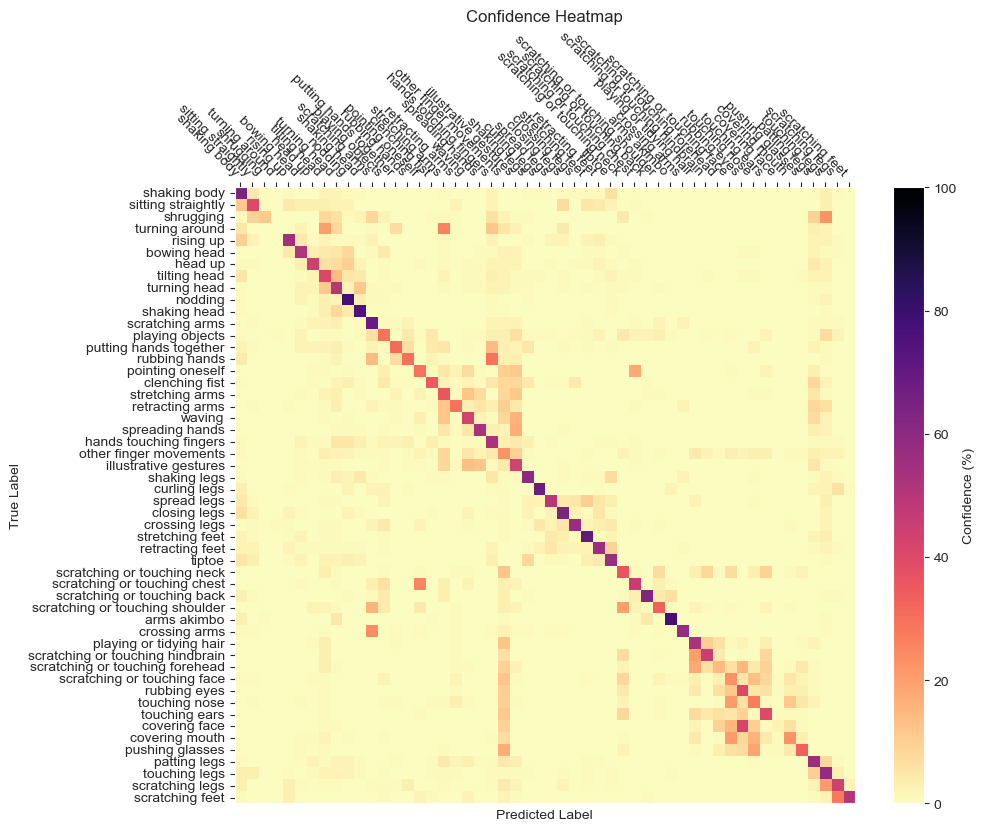

In [159]:
# y_true_df = df[gt_columns].values
# # y_true_df = y_true_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_true_df.columns})
# y_pred_df = df[logit_columns].values

y_true_df = df_fine[gt_columns_fine].values
y_pred_df = df_fine[logit_columns_fine].values

# y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
remove_features = ['head','hands','body','legs']
plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=False)

In [67]:
# y_true_df = df[gt_columns].values
# y_pred_df = df[logit_columns].values


# # y_pred_df = y_pred_df.rename(columns={a:ID2LABELS[1+int(a.split('-')[-1])] for a in y_pred_df.columns})
# remove_features = list(set(feature_names) - set(['head','hands','body','legs']))
# plot_confidence_heatmap(y_true_df, y_pred_df, feature_names, remove_features, annot=True)

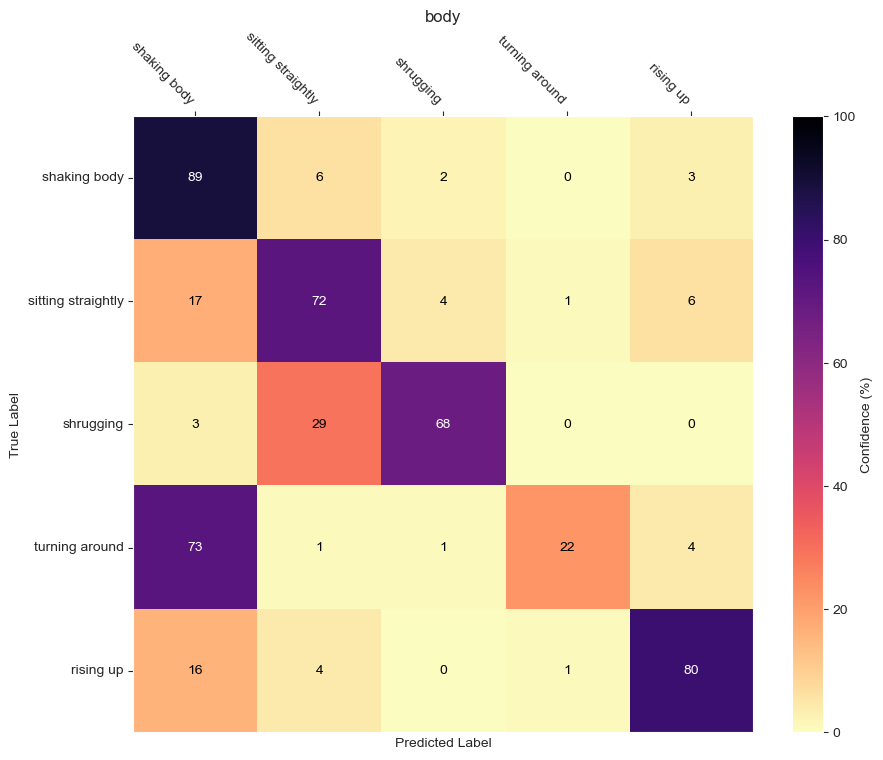

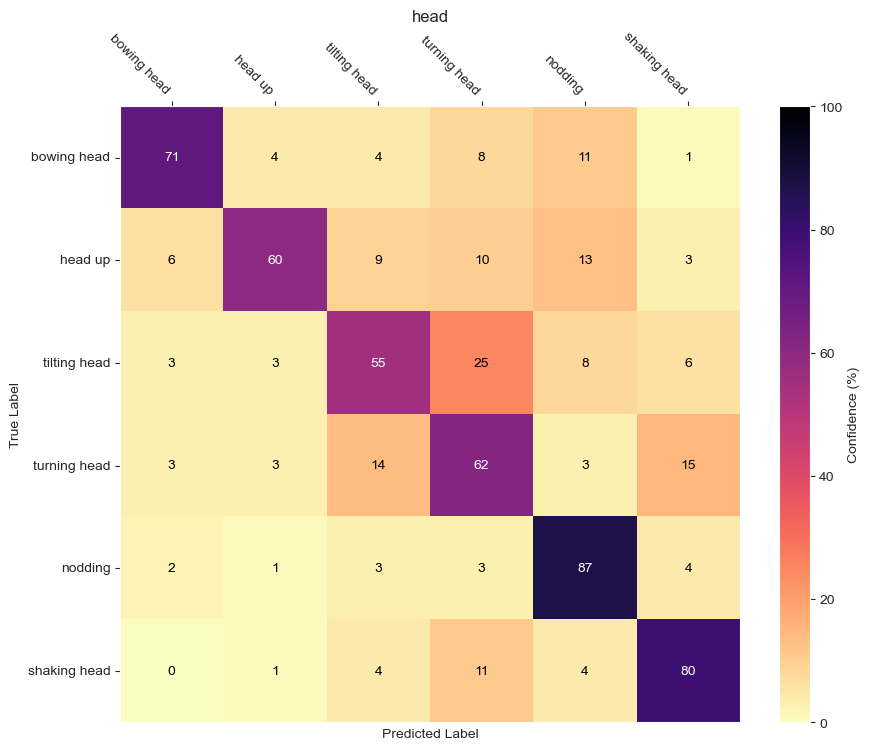

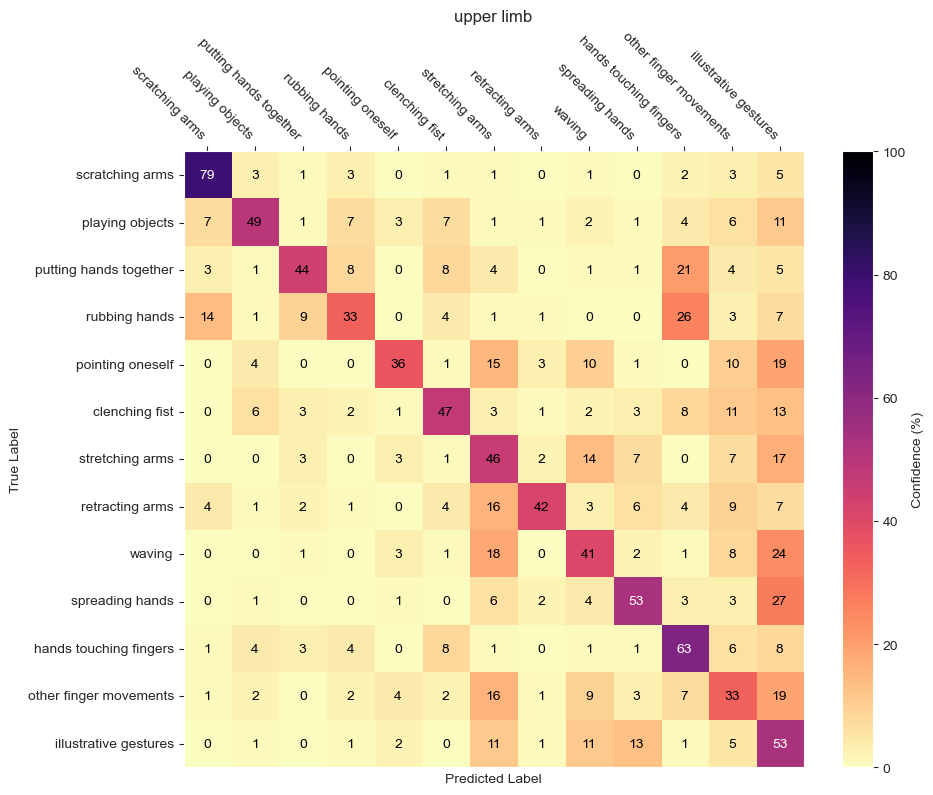

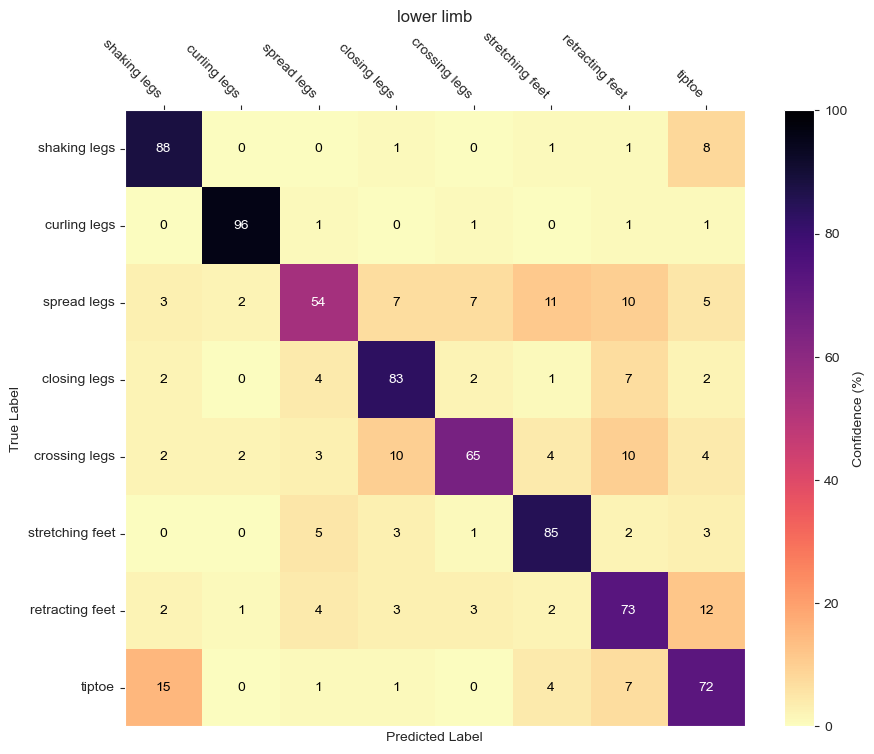

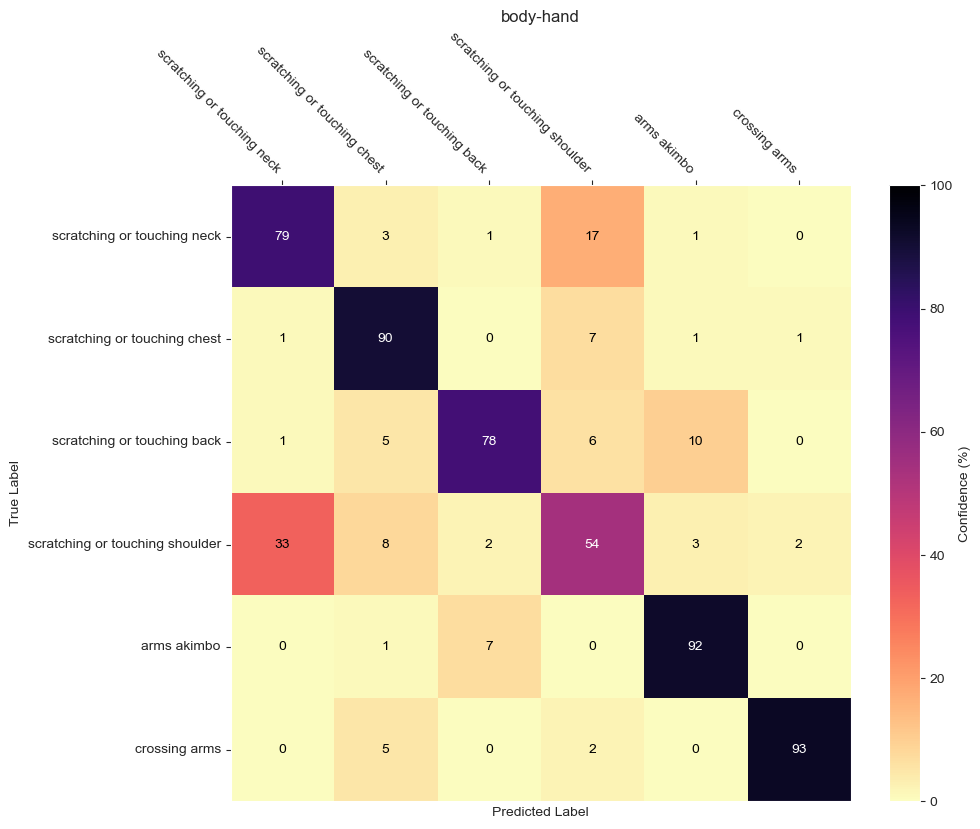

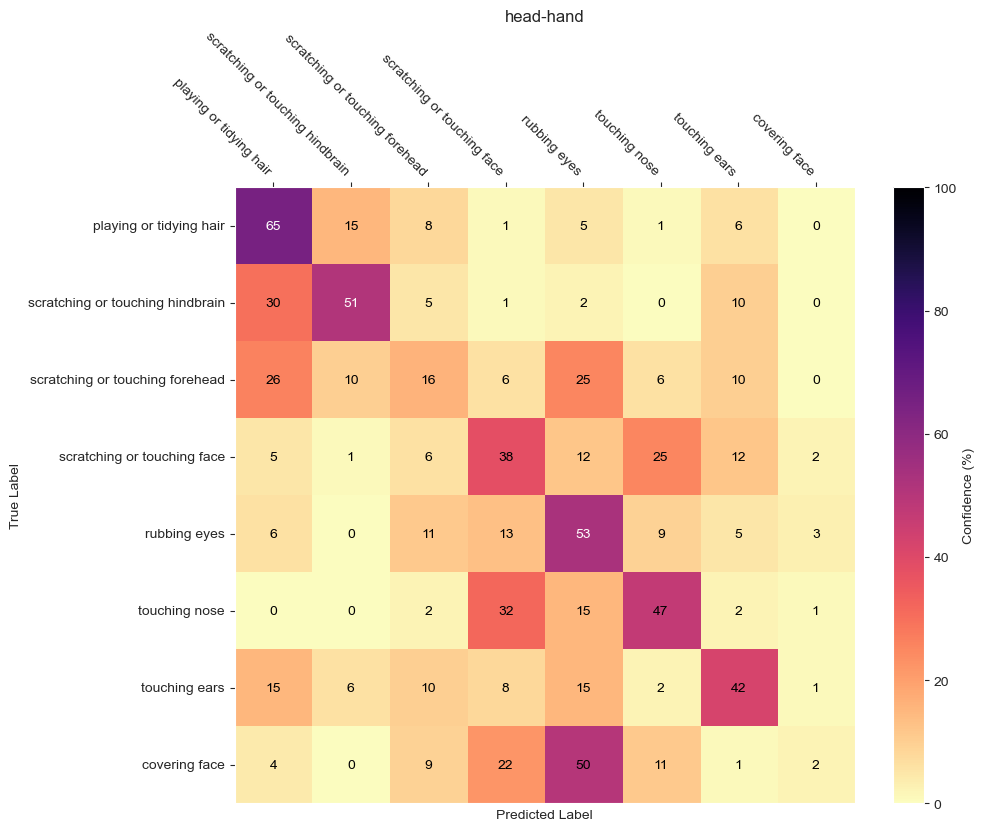

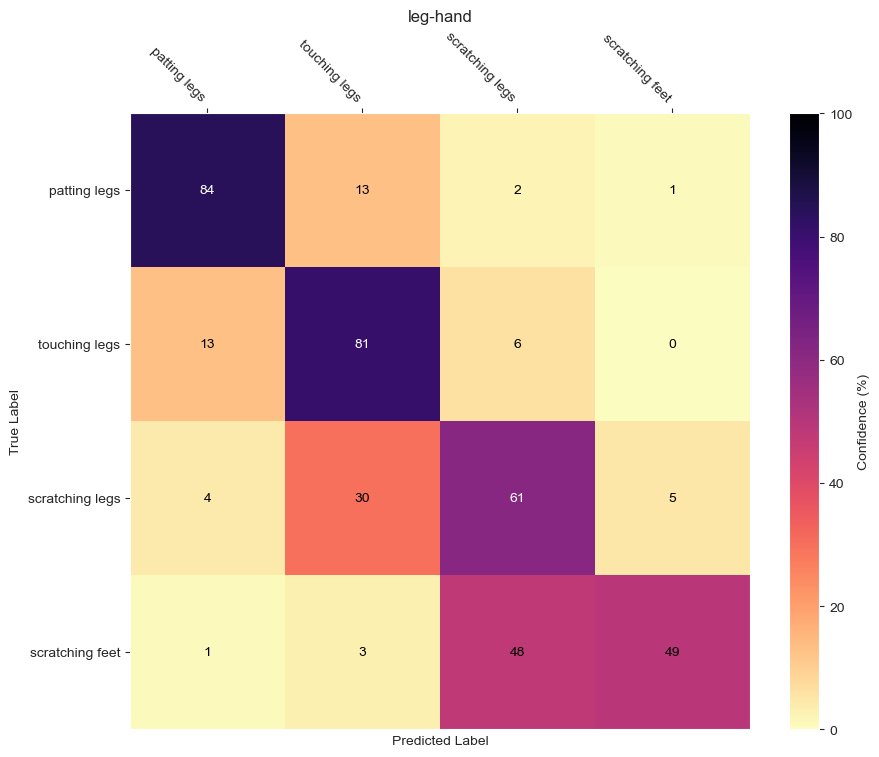

In [68]:
# fine2coarse, COARSE_LABEL, COARSE2FINE

INV_COARSE_LABEL = {v:k for k,v in COARSE_LABEL.items()}
# INV_ID2LABELS = {v:k for k,v in ID2LABELS.items()}

def coarse2fine(body_part):
    body_part_num = INV_COARSE_LABEL[body_part]
    fine_labels_num = COARSE2FINE[body_part_num]
    fine_labels = [ID2LABELS[a] for a in fine_labels_num]
    return fine_labels

coarse_labels = COARSE_LABEL.values()
for body_part in coarse_labels:
    fine_labels_temp = coarse2fine(body_part=body_part)
    gt_columns_group = [a for a in gt_columns if a.split('-')[-1] in fine_labels_temp]
    logit_columns_group = [a for a in logit_columns if a.split('-')[-1] in fine_labels_temp]
    y_true_df = df_fine[gt_columns_group].values
    y_pred_df = df_fine[logit_columns_group].values
    plot_confidence_heatmap(y_true_df, y_pred_df, feature_names=fine_labels_temp, annot=True, plot_tile=body_part)

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_mat = confusion_matrix(np.argmax(gt.values, axis=1), np.argmax(logits.values, axis=1))
# df_conf = pd.DataFrame(conf_mat.tolist(), columns=fine_labels, index=fine_labels)
# df_conf

In [70]:
# for body_part in coarse_labels:
#     fine_labels_temp = coarse2fine(body_part=body_part)
#     gt_columns_group = [a for a in gt_columns if a.split('-')[-1] in fine_labels_temp]
#     logit_columns_group = [a for a in logit_columns if a.split('-')[-1] in fine_labels_temp]
#     y_true_df = df_fine[gt_columns_group]
#     y_pred_df = df_fine[logit_columns_group]
#     conf_mat = confusion_matrix(np.argmax(y_true_df.values, axis=1), np.argmax(y_pred_df.values, axis=1))
#     disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=fine_labels_temp)
#     disp.plot()
#     plt.show()



In [71]:
gt_coarse.columns

Index(['gt-body', 'gt-head', 'gt-upper limb', 'gt-lower limb', 'gt-body-hand',
       'gt-head-hand', 'gt-leg-hand'],
      dtype='object')

In [74]:
# coarse analysis

gt_coarse_values = np.argmax(gt_coarse.values, axis=1)
pred_coarse_values = np.argmax(logits_coarse.values, axis=1)
infered_coarse_values = np.array([fine2coarse(a) for a in np.argmax(logits_fine.values, axis=1)])
sample_ind = range(len(infered_coarse_values))

In [75]:
df_coarse_comparison = pd.DataFrame([gt_coarse_values, pred_coarse_values, infered_coarse_values]).transpose()
df_coarse_comparison.columns=['gt','pred','inferred']
df_coarse_comparison.index = gt_coarse.index
df_coarse_comparison

,gt,pred,inferred
filenames,,,
0003_01_0005.mp4,1,1,1
0003_01_0006.mp4,1,1,1
0003_01_0008.mp4,1,1,1
0003_01_0015.mp4,1,1,1
0003_01_0021.mp4,1,1,1
...,...,...,...
0193_05_0006.mp4,5,5,5
0193_05_0011.mp4,5,5,5
0193_05_0013.mp4,5,5,2


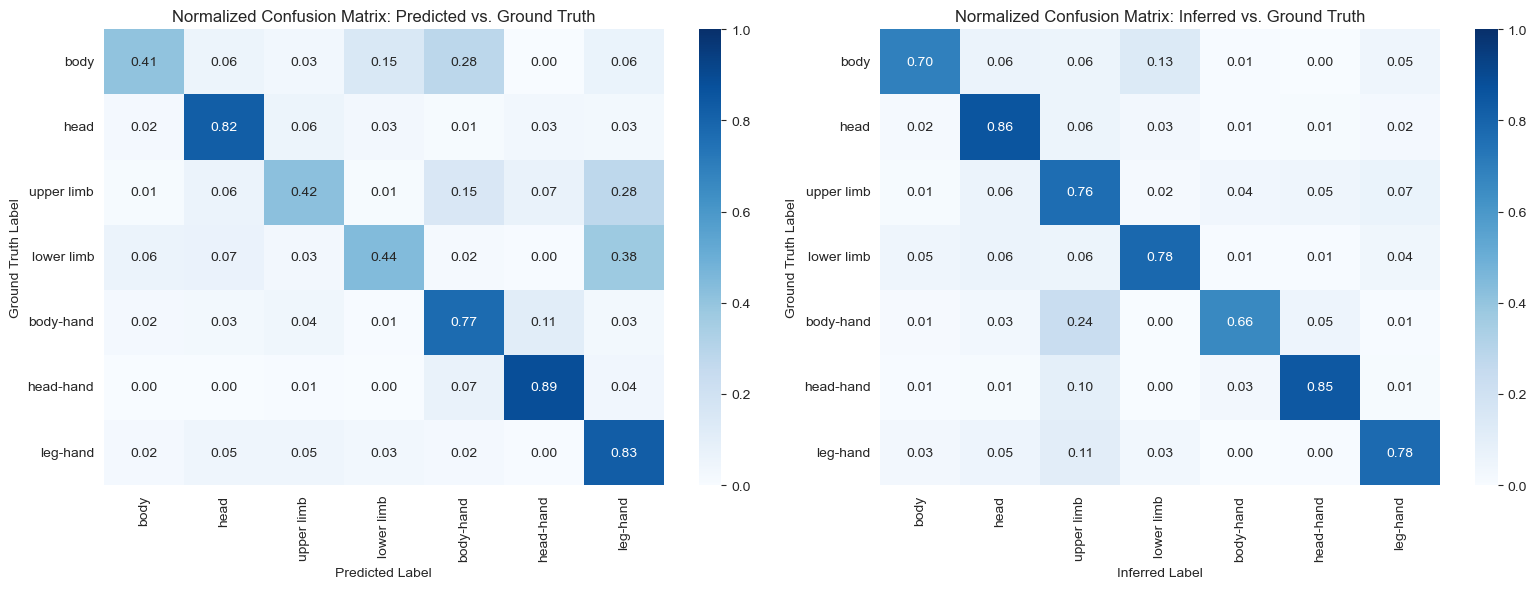

In [76]:
# Convert numerical labels to text labels
df_coarse_comparison['gt_text'] = df_coarse_comparison['gt'].map(COARSE_LABEL)
df_coarse_comparison['pred_text'] = df_coarse_comparison['pred'].map(COARSE_LABEL)
df_coarse_comparison['inferred_text'] = df_coarse_comparison['inferred'].map(COARSE_LABEL)

# # Create confusion matrices
# cm_pred = confusion_matrix(df_coarse_comparison['gt_text'], df_coarse_comparison['pred_text'], labels=list(COARSE_LABEL.values()))
# cm_inferred = confusion_matrix(df_coarse_comparison['gt_text'], df_coarse_comparison['inferred_text'], labels=list(COARSE_LABEL.values()))
# 
# # Plot confusion matrices
# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# 
# sns.heatmap(cm_pred, annot=True, fmt='d', cmap='Blues', xticklabels=list(COARSE_LABEL.values()), yticklabels=list(COARSE_LABEL.values()), ax=ax[0])
# ax[0].set_title('Confusion Matrix: Predicted vs. Ground Truth')
# ax[0].set_xlabel('Predicted Label')
# ax[0].set_ylabel('Ground Truth Label')
# 
# sns.heatmap(cm_inferred, annot=True, fmt='d', cmap='Greens', xticklabels=list(COARSE_LABEL.values()), yticklabels=list(COARSE_LABEL.values()), ax=ax[1])
# ax[1].set_title('Confusion Matrix: Inferred vs. Ground Truth')
# ax[1].set_xlabel('Inferred Label')
# ax[1].set_ylabel('Ground Truth Label')
# 
# plt.tight_layout()
# plt.show()

# Create confusion matrices
cm_pred = confusion_matrix(df_coarse_comparison['gt_text'], df_coarse_comparison['pred_text'], labels=list(COARSE_LABEL.values()))
cm_inferred = confusion_matrix(df_coarse_comparison['gt_text'], df_coarse_comparison['inferred_text'], labels=list(COARSE_LABEL.values()))

# Normalize the confusion matrices
cm_pred_normalized = cm_pred.astype('float') / cm_pred.sum(axis=1)[:, np.newaxis]
cm_inferred_normalized = cm_inferred.astype('float') / cm_inferred.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_pred_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(COARSE_LABEL.values()), yticklabels=list(COARSE_LABEL.values()), ax=ax[0],vmin=0, vmax=1)
ax[0].set_title('Normalized Confusion Matrix: Predicted vs. Ground Truth')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('Ground Truth Label')

sns.heatmap(cm_inferred_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=list(COARSE_LABEL.values()), yticklabels=list(COARSE_LABEL.values()), ax=ax[1], vmin=0, vmax=1)
ax[1].set_title('Normalized Confusion Matrix: Inferred vs. Ground Truth')
ax[1].set_xlabel('Inferred Label')
ax[1].set_ylabel('Ground Truth Label')

plt.tight_layout()
plt.show()

In [175]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.shape[1])
    batch_size = target.shape[0]
    
    # Get the indices of the top k predictions
    topk_indices = np.argsort(output, axis=1)[:, -maxk:][:, ::-1]  # Get top maxk indices
    topk_indices = np.flip(np.sort(topk_indices, axis=1), axis=1)  # Sort indices to match the PyTorch output
    
    # Check if the predictions are correct
    correct = np.equal(topk_indices, target.reshape(-1, 1))
    
    # Calculate accuracy for each k in topk
    accuracies = []
    for k in topk:
        correct_k = correct[:, :min(k, maxk)].reshape(-1).astype(np.float32)
        accuracies.append(np.sum(correct_k) * 100.0 / batch_size)
    return accuracies

In [176]:
output, target = logits_fine.values, np.argmax(gt_fine.values, axis=1) 
top1, top5 = accuracy(output, target, topk=(1,5))

In [177]:
top1

18.027210884353742

In [180]:
np.sum(np.argmax(logits_fine.values, axis=1) == np.argmax(gt_fine.values, axis=1))/len(gt_fine)*100

61.77944862155389